In [1]:
!pip install datasets

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from typing import Tuple, List
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset

In [3]:
class IMDbDataset(Dataset):
    def __init__(self, split: str, vocab: dict = None, max_length: int = 500):
        """
        Custom Dataset class for IMDb data from Hugging Face.

        Args:
            split (str): 'train' or 'test'
            vocab (dict): Vocabulary mapping (word to index), built from train if None
            max_length (int): Maximum sequence length for truncation
        """
        dataset = load_dataset("imdb", split=split)
        self.texts = [self._tokenize(row["text"])[:max_length] for row in dataset]
        self.labels = [row["label"] for row in dataset]  # 0 = negative, 1 = positive

        if vocab is None:
            self.vocab = self._build_vocab(self.texts)
        else:
            self.vocab = vocab

        self.max_length = max_length

    def _tokenize(self, text: str) -> List[str]:
        """Simple tokenization by splitting on whitespace."""
        return text.lower().split()

    def _build_vocab(self, texts: List[List[str]]) -> dict:
        """Build vocabulary from tokenized texts."""
        vocab = {"<pad>": 0, "<unk>": 1}
        word_count = {}
        for text in texts:
            for word in text:
                word_count[word] = word_count.get(word, 0) + 1
        vocab.update({word: idx + 2 for idx, (word, count) in enumerate(word_count.items()) if count > 1})
        return vocab

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        text = self.texts[idx]
        label = self.labels[idx]
        # Ensure all indices are within vocab size
        indexed = [self.vocab.get(token, self.vocab["<unk>"]) for token in text]
        # Double-check indices are valid
        indexed = [min(i, len(self.vocab) - 1) for i in indexed]  # Cap at max valid index
        return torch.tensor(indexed, dtype=torch.long), torch.tensor(label, dtype=torch.long)

def collate_batch(batch: List[Tuple[torch.Tensor, torch.Tensor]]) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """Collate function for DataLoader to handle variable-length sequences."""
    texts, labels = zip(*batch)
    lengths = torch.tensor([len(text) for text in texts], dtype=torch.long)
    padded_texts = pad_sequence(texts, batch_first=True, padding_value=0)  # <pad> index is 0
    labels = torch.tensor(labels, dtype=torch.long)
    return padded_texts, labels, lengths

In [4]:

class GRUClassifier(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int = 100, hidden_size: int = 256,
                 output_size: int = 2, num_layers: int = 1, dropout: float = 0.5):
        """
        Initialize the GRU-based classifier for sentiment prediction.

        Parameters:
            vocab_size (int): Size of the vocabulary for the embedding layer
            embedding_dim (int): Dimension of the word embeddings
            hidden_size (int): Size of the GRU hidden state
            output_size (int): Number of output classes (default is 2 for binary sentiment)
            num_layers (int): Number of GRU layers
            dropout (float): Dropout rate for regularization
        """
        super(GRUClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)

        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize network weights using Xavier initialization."""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.GRU):
                for name, param in m.named_parameters():
                    if 'weight' in name:
                        nn.init.xavier_normal_(param)
                    elif 'bias' in name:
                        nn.init.zeros_(param)
            elif isinstance(m, nn.Embedding):
                nn.init.xavier_normal_(m.weight)

    def forward(self, x: torch.Tensor, lengths: torch.Tensor) -> torch.Tensor:
        """
        Perform the forward pass through the network.

        Parameters:
            x (torch.Tensor): Input batch of token indices (batch_size, max_seq_len)
            lengths (torch.Tensor): Original sequence lengths (batch_size)

        Returns:
            torch.Tensor: Output predictions of shape (batch_size, output_size)
        """
        embedded = self.dropout(self.embedding(x))  # (batch_size, max_seq_len, embedding_dim)
        packed_embedded = pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, hidden = self.gru(packed_embedded)
        final_hidden = hidden[-1]  # (batch_size, hidden_size)
        output = self.fc(self.dropout(final_hidden))
        return output

    def train_model(self,
                    train_loader: DataLoader,
                    test_loader: DataLoader,
                    num_epochs: int,
                    learning_rate: float,
                    device: torch.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
                    patience: int = 2):
        """
        Train the GRU model and log metrics.

        Parameters:
            train_loader (DataLoader): DataLoader for training data
            test_loader (DataLoader): DataLoader for test data
            num_epochs (int): Number of training epochs
            learning_rate (float): Learning rate for the optimizer
            device (torch.device): Device to run training on (default: CUDA if available, else CPU)
            patience (int): Number of epochs to wait for improvement before early stopping
        """
        self.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)

        train_losses = []
        train_accuracies = []
        test_accuracies = []
        best_test_acc = 0
        patience_counter = 0

        for epoch in range(num_epochs):
            self.train()
            running_loss = 0.0
            correct = 0
            total = 0

            for i, (texts, labels, lengths) in enumerate(train_loader):
                texts, labels = texts.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = self(texts, lengths)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                running_loss += loss.item()

                if i % 20 == 19:
                    print(f'[Epoch {epoch + 1}, Batch {i + 1}] Loss: {running_loss/100:.4f}')
                    running_loss = 0.0

            epoch_loss = running_loss / len(train_loader)
            epoch_accuracy = 100 * correct / total
            test_accuracy = self.evaluate(test_loader, device)

            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_accuracy)
            test_accuracies.append(test_accuracy)

            print(f'Epoch {epoch + 1}/{num_epochs}:')
            print(f'Training Loss: {epoch_loss:.4f}')
            print(f'Training Accuracy: {epoch_accuracy:.2f}%')
            print(f'Test Accuracy: {test_accuracy:.2f}%')
            print('-' * 60)

            # Early stopping
            if test_accuracy > best_test_acc:
                best_test_acc = test_accuracy
                patience_counter = 0
                torch.save(self.state_dict(), 'best_model.pt')  # Save best model
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch + 1} epochs")
                    break

        # Load best model
        self.load_state_dict(torch.load('best_model.pt'))
        history = {
            'train_loss': train_losses,
            'train_acc': train_accuracies,
            'test_acc': test_accuracies
        }
        return history

    def predict(self,
                test_loader: DataLoader,
                device: torch.device) -> List[int]:
        """
        Make predictions using GPU if available.

        Parameters:
            test_loader (DataLoader): DataLoader for test data
            device (torch.device): Device to run predictions on

        Returns:
            List[int]: List of predicted class indices
        """
        self.eval()
        predictions = []

        with torch.no_grad():
            for texts, _, lengths in test_loader:
                texts = texts.to(device)
                outputs = self(texts, lengths)
                _, predicted = torch.max(outputs.data, 1)
                predictions.extend(predicted.cpu().numpy())

        return predictions

    def evaluate(self,
                 test_loader: DataLoader,
                 device: torch.device) -> float:
        """
        Evaluate model accuracy using GPU if available.

        Parameters:
            test_loader (DataLoader): DataLoader for test data
            device (torch.device): Device to run evaluation on

        Returns:
            float: Accuracy percentage on the test set
        """
        self.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for texts, labels, lengths in test_loader:
                texts, labels = texts.to(device), labels.to(device)
                outputs = self(texts, lengths)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f'Accuracy on test set: {accuracy:.2f}%')
        return accuracy

def plot_training_history(history):
    """Plot training loss and accuracies."""
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['test_acc'], label='Test Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [5]:
# Data Preparation
train_dataset = IMDbDataset(split="train")
test_dataset = IMDbDataset(split="test", vocab=train_dataset.vocab)

BATCH_SIZE = 128
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [6]:
# Model Initialization and Training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GRUClassifier(vocab_size=len(train_dataset.vocab), embedding_dim=100, hidden_size=256,
                      output_size=2, num_layers=2, dropout=0.5).to(device)

history = model.train_model(train_loader=train_loader, test_loader=test_loader, num_epochs=5,
                            learning_rate=0.001, device=device)

[Epoch 1, Batch 20] Loss: 0.1384
[Epoch 1, Batch 40] Loss: 0.1285
[Epoch 1, Batch 60] Loss: 0.1140
[Epoch 1, Batch 80] Loss: 0.1191
[Epoch 1, Batch 100] Loss: 0.1020
[Epoch 1, Batch 120] Loss: 0.0880
[Epoch 1, Batch 140] Loss: 0.0720
[Epoch 1, Batch 160] Loss: 0.0792
[Epoch 1, Batch 180] Loss: 0.0668
Accuracy on test set: 84.34%
Epoch 1/5:
Training Loss: 0.0324
Training Accuracy: 75.92%
Test Accuracy: 84.34%
------------------------------------------------------------
[Epoch 2, Batch 20] Loss: 0.0588
[Epoch 2, Batch 40] Loss: 0.0438
[Epoch 2, Batch 60] Loss: 0.0448
[Epoch 2, Batch 80] Loss: 0.0457
[Epoch 2, Batch 100] Loss: 0.0381
[Epoch 2, Batch 120] Loss: 0.0477
[Epoch 2, Batch 140] Loss: 0.0473
[Epoch 2, Batch 160] Loss: 0.0429
[Epoch 2, Batch 180] Loss: 0.0372
Accuracy on test set: 84.54%
Epoch 2/5:
Training Loss: 0.0186
Training Accuracy: 91.40%
Test Accuracy: 84.54%
------------------------------------------------------------
[Epoch 3, Batch 20] Loss: 0.0187
[Epoch 3, Batch 40] L

<ipython-input-4-c8a807c65ef2>:115: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load('best_model.pt'))


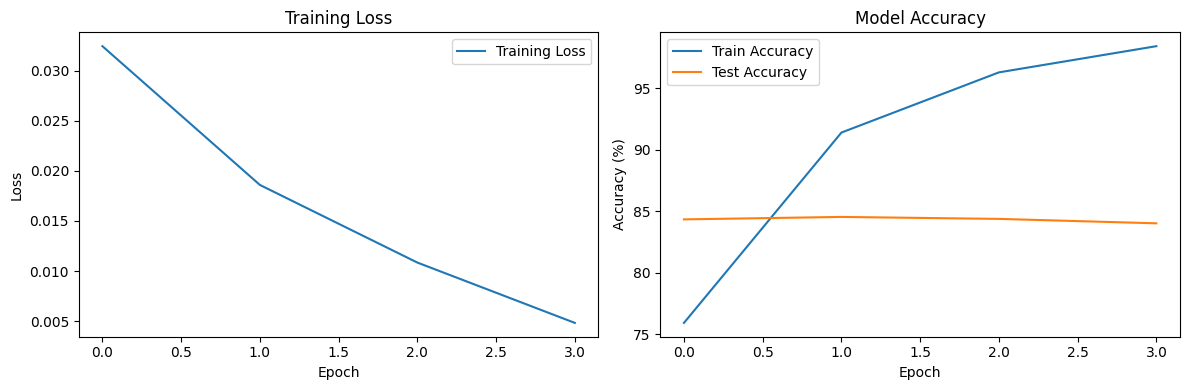

Sample review: This movie was fantastic and thrilling!
Predicted sentiment: Positive


In [7]:
# Plot Results
plot_training_history(history)

# Example Prediction
def predict_sentiment(model, text: str, vocab: dict, device):
    model.eval()
    tokens = text.lower().split()
    indexed = [vocab.get(token, vocab["<unk>"]) for token in tokens]
    tensor = torch.tensor(indexed, dtype=torch.long).unsqueeze(0).to(device)
    length = torch.tensor([len(indexed)], dtype=torch.long)
    with torch.no_grad():
        output = model(tensor, length)
        _, predicted = torch.max(output, 1)
    return "Positive" if predicted.item() == 1 else "Negative"

sample_review = "This movie was fantastic and thrilling!"
print(f"Sample review: {sample_review}")
print(f"Predicted sentiment: {predict_sentiment(model, sample_review, train_dataset.vocab, device)}")